In [1]:
import sys; sys.path.append('..') # add project root to the python path

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.part2.temporal_difference import TDAgent
from src.common.gridworld import GridworldEnv
from src.common.grid_visualization import visualize_value_function, visualize_policy

np.random.seed(0)

## `GridWorld` 초기화하기

가로로 `nx` 개, 세로로 `ny` 개의 칸을 가진 `GridworldEnv`를 만듭니다!

In [3]:
nx, ny = 4, 4
env = GridworldEnv([ny, nx])

## Temporal-difference '에이전트' 초기화하기

Temporal difference 에이전트를 초기화 해볼까요? TD 에이전트의 컨스트럭터는 다음과 같습니다.

```python
class TDAgent:
    def __init__(self,
                 gamma: float,
                 num_states: int,
                 num_actions: int,
                 epsilon: float,
                 lr: float,
                 n_step: int):
```

각각의 인자들의 의미부터 살펴볼까요?
1. `gamma` : 감가율
2. `num_states` : 상태공간의 크기 (서로 다른 상태의 갯수)
3. `num_actions` : 행동공간의 크기 (서로 다른 행동의 갯수)
4. `epsilon`: $\epsilon$-탐욕적 정책의 파라미터
5. `lr`: 학습률 $\alpha$
6. `n-step`: 리턴 추산에 사용할 스텝의 수

In [4]:
td_agent = TDAgent(gamma=1.0,
                   num_states=nx * ny,
                   num_actions=4,
                   epsilon=1.0,
                   lr=1e-2,
                   n_step=1)

## 1-step TD; TD(0)

1-step TD &ndash; 혹은 TD(0) &ndash; 의 사례부터 살펴보도록 하죠. 1-step TD의 업데이트 공식은 다음과 같습니다.

$$V(s) \leftarrow V(s) + \alpha (G_t - V(s))$$ 
$$G_t = R_{t+1} + \gamma V(s_{t+1}) $$

수식에서도 확인하실수 있듯이, 1-step TD는 $(s_t, a_t, r_t, s_{t+1})$ 만으로도 업데이트를 수행할 수 있습니다. 이러한 특성을 고려해서 `run_episode()` 함수를 디자인해볼까요?

In [5]:
def run_episode(env, agent):
    env.reset()
    
    while True:
        state = env.observe()
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        agent.sample_update(state=state, 
                            action=action, 
                            reward=reward,
                            next_state=next_state,
                            done=done)
        
        if done:
            break

## agent.sample_update() ?

TD 에이전트의 MC 장점 중 하나는 episode가 다 끝나지 않아도 업테이트를 수행할 수 있었다는 점이 있었죠? 그 특성을 활용해서 상태 및 행동 가치함수를 업데이트하는 코드를 살펴보죠.

```python
def sample_update(self, state, action, reward, next_state, done):
    # 1-step TD target
    td_target = reward + self.gamma * self.v[next_state] * (1 - done)
    self.v[state] += self.lr * (td_target - self.v[state])

```

In [6]:
total_eps = 10000
log_every = 1000

def run_episodes(env, agent, total_eps, log_every):
    values = []
    log_iters = []
    
    for i in range(total_eps+1):  
        run_episode(env, agent)

        if i % log_every == 0:
            values.append(agent.v.copy())
            log_iters.append(i)
    
    info = dict()
    info['values'] = values
    info['iters'] = log_iters
    return info

In [7]:
td_agent.reset_values()
info = run_episodes(env, td_agent, total_eps, log_every)

In [8]:
log_iters = info['iters']
mc_values = info['values']

In [9]:
from src.part2.tensorized_dp import TensorDP

dp_agent = TensorDP()
dp_agent.set_env(env)
v_pi = dp_agent.policy_evaluation()

Tensor DP agent initialized
Environment spec:  Num. state = 16 | Num. actions = 4 


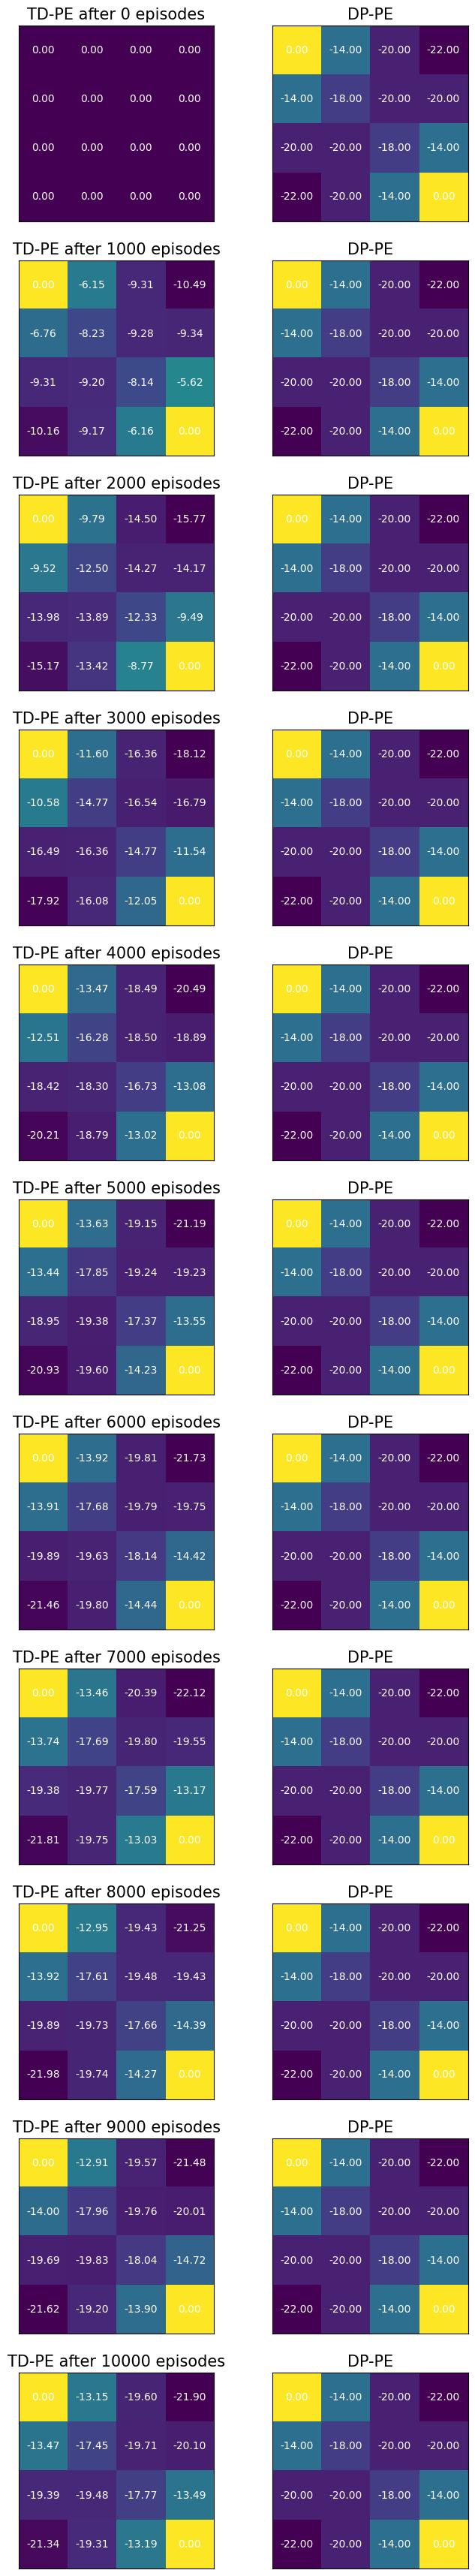

In [10]:
n_rows = len(log_iters)
figsize_multiplier = 4


fig, ax = plt.subplots(n_rows, 2, figsize=(2*figsize_multiplier, 
                                           n_rows*figsize_multiplier))

for viz_i, i in enumerate(log_iters):
    visualize_value_function(ax[viz_i, 0], mc_values[viz_i], nx, ny,
                            plot_cbar=False)
    _ = ax[viz_i, 0].set_title("TD-PE after {} episodes".format(i), size=15)

    visualize_value_function(ax[viz_i, 1], v_pi, nx, ny,
                             plot_cbar=False)
    _ = ax[viz_i, 1].set_title("DP-PE", size=15)

## 여러번 반복실험을 통해서 분산을 추정해보도록 할까요?

In [11]:
reps = 10
values_over_runs = []
total_eps = 3000
log_every = 30

for i in range(reps):
    td_agent.reset_values()
    print("start to run {} th experiment ... ".format(i))
    info = run_episodes(env, td_agent, total_eps, log_every)
    values_over_runs.append(info['values'])
    
values_over_runs = np.stack(values_over_runs)

start to run 0 th experiment ... 
start to run 1 th experiment ... 
start to run 2 th experiment ... 
start to run 3 th experiment ... 
start to run 4 th experiment ... 
start to run 5 th experiment ... 
start to run 6 th experiment ... 
start to run 7 th experiment ... 
start to run 8 th experiment ... 
start to run 9 th experiment ... 


In [12]:
v_pi_expanded = np.expand_dims(v_pi, axis=(0,1))

In [13]:
errors = np.linalg.norm(values_over_runs - v_pi_expanded, axis=-1)
error_mean = np.mean(errors, axis=0)
error_std = np.std(errors, axis=0)

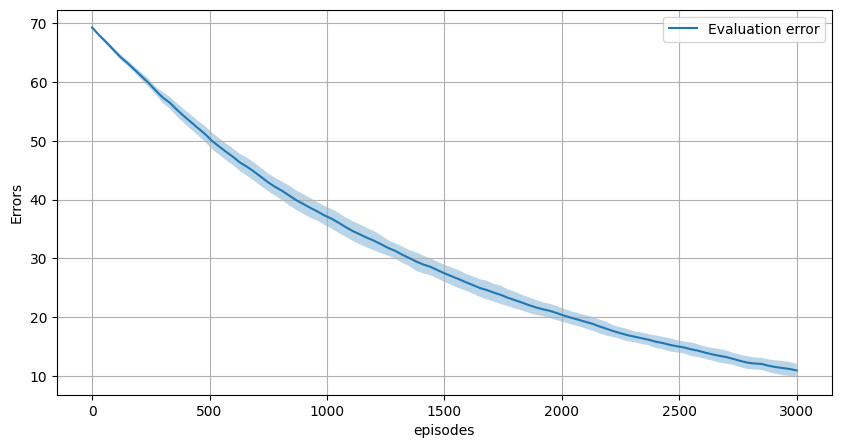

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.grid()
ax.fill_between(x=info['iters'],
                y1=error_mean + error_std,
                y2=error_mean - error_std,
                alpha=0.3)
ax.plot(info['iters'], error_mean, label='Evaluation error')
ax.legend()
_ = ax.set_xlabel('episodes')
_ = ax.set_ylabel('Errors')

## Monte-carlo 기법과 비교해보기!

강의에서 MC기법은 &ndash; 상대적으로 &ndash; TD에 비해 분산이 높다고 이야기했었는데 과연 사실일까요? 한번 확인해보도록 하죠.

In [15]:
mc_errors = np.load('mc_errors.npy')
mc_error_mean = np.mean(mc_errors, axis=0)
mc_error_std = np.std(mc_errors, axis=0)

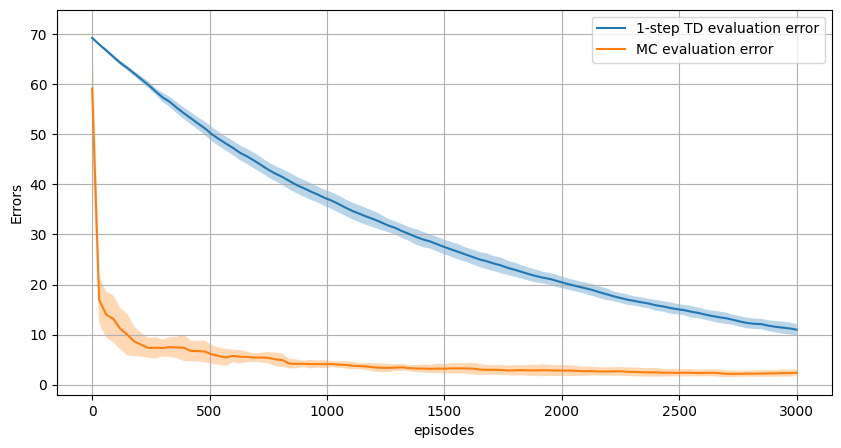

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.grid()
ax.fill_between(x=info['iters'],
                y1=error_mean + error_std,
                y2=error_mean - error_std,
                alpha=0.3)
ax.plot(info['iters'], error_mean, label='1-step TD evaluation error')

ax.fill_between(x=info['iters'],
                y1=mc_error_mean + mc_error_std,
                y2=mc_error_mean - mc_error_std,
                alpha=0.3)
ax.plot(info['iters'], mc_error_mean, label='MC evaluation error')
ax.legend()
_ = ax.set_xlabel('episodes')
_ = ax.set_ylabel('Errors')

## 여러 스텝의 보상함수를 같이 활용하는 n-step TD

이번에는 n-step TD에 대해서 실습을 해보도록 할까요?

In [17]:
n_steps = 5
n_step_td_agent = TDAgent(gamma=1.0,
                          num_states=nx * ny,
                          num_actions=4,
                          epsilon=1.0,
                          lr=1e-2,
                          n_step=n_steps)

## n-step TD의 target

n-step TD 는 직후 보상뿐만 아니라 n-step 뒤의 보상까지 return 추산에 사용합니다. 다시 한번 n-step TD의 target을 알아볼까요?

$$ G_t^{n} = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots + \gamma^{n-1} R_{t+n} + \gamma^n V(S_{t+n}) $$

n-step TD를 구현할 때는 대부분의 경우 episodic 한 형태로 구현하게 됩니다. 이는 당연히 각 에피소드의 길이가 random variable 이기 때문이죠.
따라서 이번 시간에 실습할 구현체도, 이전의 1-step TD와는 다르게, episodic 한 형태로 구현해보았습니다.

In [18]:
def run_episode(env, agent):
    env.reset()
    states = []
    actions = []
    rewards = []
    
    while True:
        state = env.observe()
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        if done:
            break
    
    episode = (states, actions, rewards)
    agent.update(episode)

## agent.update() ?

n-step TD는 1-step TD 및 MC보다 조금 더 신경써야할 부분이 있습니다. episode의 끝 근처에서 `n-step` 보다 짧게 남은 state 들에 대한 리턴을 추산 할 때인데요. 예를 들어보면 다음과 같은 상황입니다. 

> 에피소드의 길이가 10 이고, `n-step` 이 2 라고 가정해봅시다. 그러면 9번 째로 방문한 상태 $S_9$ 에 해당하는 타겟은 어떻게 정의될까요?
> $$ G_9 = R_{10} + \gamma R_{11} + \gamma^2 V(S_{11}) $$
> 문제는 $R_{11}$ 및 $S_{11}$ 이 존재하지 않는다는 것!

### 방법 1. $S_9$ 부터는 추산 대상에서 제외한다.
정의상 $V(S_9)$ 를 추산할 때 틀린 방법은 아니지만, 다른 state 들의 $V(s)$ 를 추산할 때 부정확한 $V(S_9)$ 를 사용하게 되니 골치가 아프겠죠.

### 방법 2. MDP의 정의를 잘 생각해본다.
이전에도 이미 우리는 `done`을 활용해서 종결 상태의 가치함수가 다른 상태의 가치함수 추산에 영향을 주지 않도록 했습니다.

```python
    td_target = reward + self.gamma * self.v[next_state] * (1 - done)
```

우리는 종결상태에 agent가 방문하게 되면 하나의 '에피소드가 끝났다!' 라고 정하고 다음 에피소드로 넘어갔었습니다. 우리는 이런 에피소드의 구조를 조금 다르게 생각해볼 수도 있습니다. MDP 수업에서 이야기 나눴듯, agent가 종결상태에 방문하게 되면 어느 행동을 하든 종결상태로 __되 돌아오고__ 그에 따른 __보상은 0__으로 바라 볼 수도 있습니다.

이런 관점에서 바라보면, 이는 결국 종결상태의 가치함수는 0이 되고 위의 구현도 좀 더 자연스럽게 해석해 볼 수 있죠. 유사한 해석을 n-step TD의 타겟을 추산할 때도 같은 방식을 적용할 수 있습니다.

이제 한번 `agent.update()` 함수를 살펴볼까요?
```python
def update(self, episode):
    states, actions, rewards = episode
    ep_len = len(states)

    states += [0] * (self.n_step + 1)  # append dummy states
    rewards += [0] * (self.n_step + 1)  # append dummy rewards
    dones = [0] * ep_len + [1] * (self.n_step + 1)

    kernel = np.array([self.gamma ** i for i in range(self.n_step)])
    for i in range(ep_len):
        s = states[i]
        ns = states[i + self.n_step]
        done = dones[i]

        # compute n-step TD target
        g = np.sum(rewards[i:i + self.n_step] * kernel)
        g += (self.gamma ** self.n_step) * self.v[ns] * (1 - done)
        self.v[s] += self.lr * (g - self.v[s])
```

In [19]:
n_step_td_agent.reset_values()
info = run_episodes(env, n_step_td_agent, 2000, 500)

In [20]:
log_iters = info['iters']
mc_values = info['values']

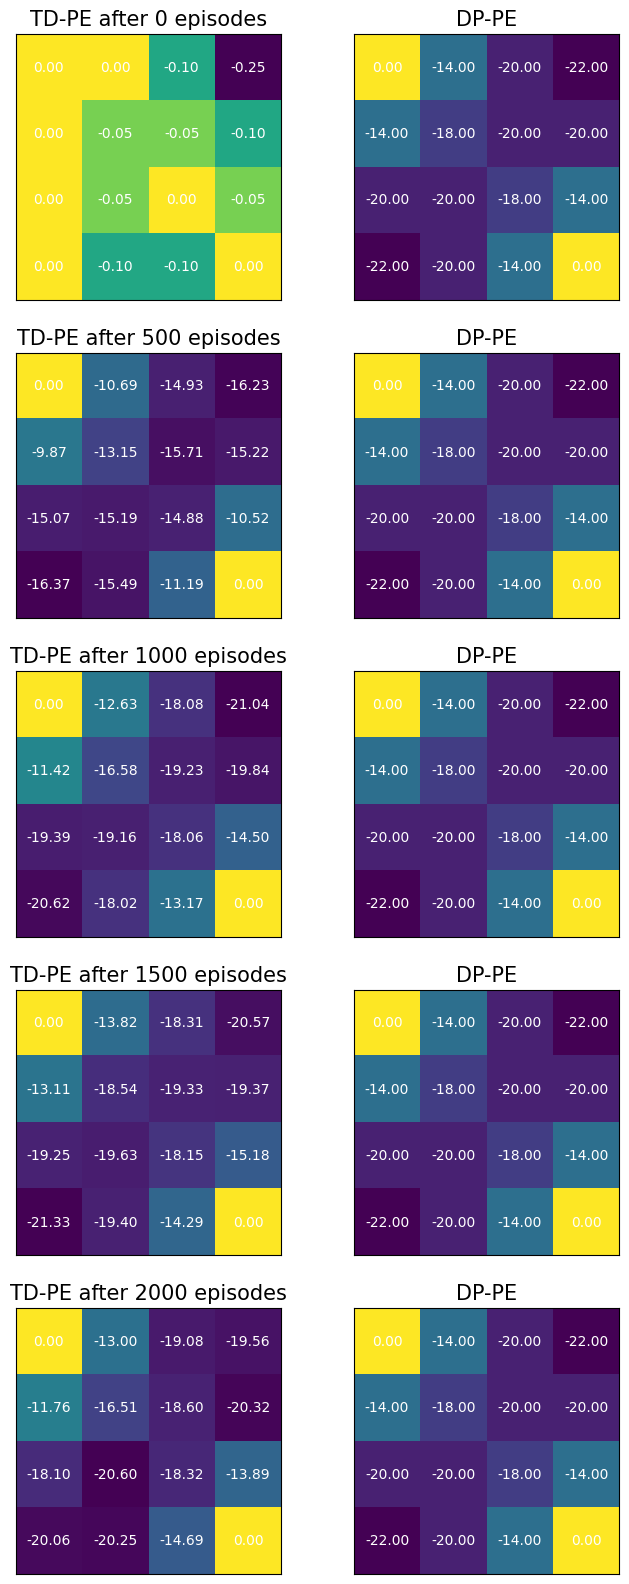

In [21]:
n_rows = len(log_iters)
figsize_multiplier = 4


fig, ax = plt.subplots(n_rows, 2, figsize=(2*figsize_multiplier, 
                                           n_rows*figsize_multiplier))

for viz_i, i in enumerate(log_iters):
    visualize_value_function(ax[viz_i, 0], mc_values[viz_i], nx, ny,
                            plot_cbar=False)
    _ = ax[viz_i, 0].set_title("TD-PE after {} episodes".format(i), size=15)

    visualize_value_function(ax[viz_i, 1], v_pi, nx, ny,
                             plot_cbar=False)
    _ = ax[viz_i, 1].set_title("DP-PE", size=15)

## n-step TD와 1-step TD 비교하기

In [22]:
reps = 10
values_over_runs = []
total_eps = 3000
log_every = 30

for i in range(reps):
    n_step_td_agent.reset_values()
    print("start to run {} th experiment ... ".format(i))
    info = run_episodes(env, n_step_td_agent, total_eps, log_every)
    values_over_runs.append(info['values'])
    
n_step_values_over_runs = np.stack(values_over_runs)

start to run 0 th experiment ... 
start to run 1 th experiment ... 
start to run 2 th experiment ... 
start to run 3 th experiment ... 
start to run 4 th experiment ... 
start to run 5 th experiment ... 
start to run 6 th experiment ... 
start to run 7 th experiment ... 
start to run 8 th experiment ... 
start to run 9 th experiment ... 


In [23]:
n_step_errors = np.linalg.norm(n_step_values_over_runs - v_pi_expanded, axis=-1)
n_step_error_mean = np.mean(n_step_errors, axis=0)
n_step_error_std = np.std(n_step_errors, axis=0)

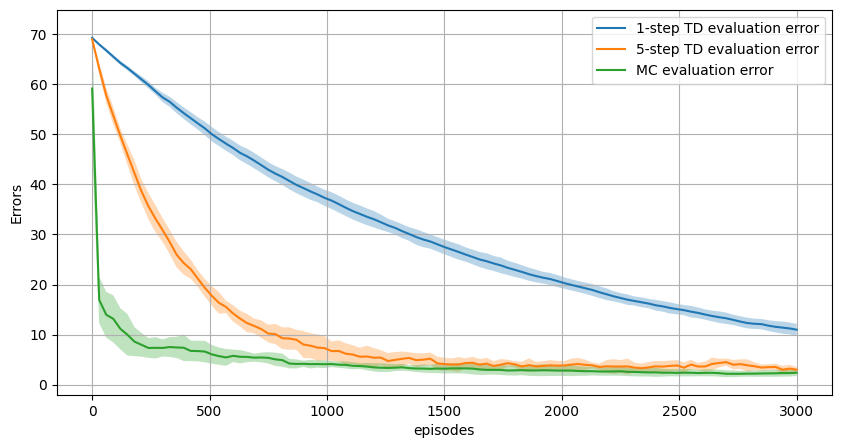

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.grid()
ax.fill_between(x=info['iters'],
                y1=error_mean + error_std,
                y2=error_mean - error_std,
                alpha=0.3)
ax.plot(info['iters'], error_mean, label='1-step TD evaluation error')

ax.fill_between(x=info['iters'],
                y1=n_step_error_mean + n_step_error_std,
                y2=n_step_error_mean - n_step_error_std,
                alpha=0.3)
ax.plot(info['iters'], n_step_error_mean, label='{}-step TD evaluation error'.format(n_steps))

ax.fill_between(x=info['iters'],
                y1=mc_error_mean + mc_error_std,
                y2=mc_error_mean - mc_error_std,
                alpha=0.3)
ax.plot(info['iters'], mc_error_mean, label='MC evaluation error')


ax.legend()
_ = ax.set_xlabel('episodes')
_ = ax.set_ylabel('Errors')